In [ ]:
# This notebook contains the experiment setup and plotting for the supplier agent
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Initial imports
import importlib
import params
import agents
import model

from model import NewsVendorModel

# ============================================================================
# EXPERIMENT GROUP 1: TEAM PLAYER SUPPLIER (Integrated Supply Chain)
# ============================================================================
print("=" * 80)
print("GROUP 1: TEAM PLAYER SUPPLIER MODE (Retailer-Only Metrics)")
print("=" * 80)

# Set to team player mode and recompute benchmarks
params.SUPPLIER_TEAM_PLAYER = True
params._compute_benchmarks()

print(f"\n🔍 Configuration:")
print(f"   SUPPLIER_TEAM_PLAYER: {params.SUPPLIER_TEAM_PLAYER}")
print(f"   Supplier action space: {params.action_space_c()}")
print(f"   Number of benchmarks: {len(params.PROFIT_OPTIMA_MAP)}\n")

experiments_team_player = [
    # (agent_types, use_partner_prediction, description)
    (['greedy', 'greedy', 'greedy'], False, 'Greedy-Greedy, No Prediction'),
    (['greedy', 'greedy', 'greedy'], True, 'Greedy-Greedy, With Prediction'),
    (['ucb', 'ucb', 'ucb'], False, 'UCB-UCB, No Prediction'),
    (['ucb', 'ucb', 'ucb'], True, 'UCB-UCB, With Prediction'),
    (['thompson', 'thompson', 'thompson'], False, 'Thompson-Thompson, No Prediction'),
    (['thompson', 'thompson', 'thompson'], True, 'Thompson-Thompson, With Prediction'),
    (['greedy', 'ucb', 'greedy'], False, 'Greedy(P)-UCB(Q), No Prediction'),
    (['greedy', 'ucb', 'greedy'], True, 'Greedy(P)-UCB(Q), With Prediction'),
    (['ucb', 'greedy', 'ucb'], False, 'UCB(P)-Greedy(Q), No Prediction'),
    (['ucb', 'greedy', 'ucb'], True, 'UCB(P)-Greedy(Q), With Prediction'),
    (['greedy', 'thompson', 'greedy'], False, 'Greedy(P)-Thompson(Q), No Prediction'),
    (['greedy', 'thompson', 'greedy'], True, 'Greedy(P)-Thompson(Q), With Prediction'),
    (['thompson', 'greedy', 'thompson'], False, 'Thompson(P)-Greedy(Q), No Prediction'),
    (['thompson', 'greedy', 'thompson'], True, 'Thompson(P)-Greedy(Q), With Prediction'),
    (['thompson', 'ucb', 'thompson'], False, 'Thompson(P)-UCB(Q), No Prediction'),
    (['thompson', 'ucb', 'thompson'], True, 'Thompson(P)-UCB(Q), With Prediction'),
    (['ucb', 'thompson', 'ucb'], False, 'UCB(P)-Thompson(Q), No Prediction'),
    (['ucb', 'thompson', 'ucb'], True, 'UCB(P)-Thompson(Q), With Prediction'),
]

team_player_results = []

for idx, (agent_types, use_prediction, description) in enumerate(experiments_team_player, 1):
    print(f"\n[{idx}/{len(experiments_team_player)}] {description}")
    print(f"  Price: {agent_types[0]}, Quantity: {agent_types[1]}, Prediction: {use_prediction}")
    
    params.USE_PARTNER_PREDICTION = use_prediction
    
    sim_model = NewsVendorModel(agent_type=agent_types)
    
    for i in range(params.ROUNDS):
        sim_model.step()
    
    model_df = sim_model.datacollector.get_model_vars_dataframe()
    agent_df = sim_model.datacollector.get_agent_vars_dataframe()
    
    df = agent_df.reset_index()
    price_data = df[df["AgentID"] == 1][["Step", "Action", "Reward"]].rename(columns={"Action": "Price"})
    qty_data = df[df["AgentID"] == 2][["Step", "Action"]].rename(columns={"Action": "Quantity"})
    supplier_data = df[df["AgentID"] == 3][["Step", "Action"]].rename(columns={"Action": "Cost"})
    
    combined_df = pd.merge(price_data, qty_data, on="Step")
    combined_df = pd.merge(combined_df, supplier_data, on="Step")
    combined_df = pd.merge(combined_df, model_df, left_on="Step", right_index=True)
    
    # Retailer metrics only
    final_regret = combined_df['Regret'].cumsum().iloc[-1]
    avg_profit = combined_df['Reward'].mean()
    final_price = combined_df['Price'].iloc[-100:].mean()
    final_quantity = combined_df['Quantity'].iloc[-100:].mean()
    price_std = combined_df['Price'].iloc[-100:].std()
    qty_std = combined_df['Quantity'].iloc[-100:].std()
    
    optimal_profit = params.PROFIT_OPTIMA_MAP.get(params.MANUFACTURING_COST, 0)
    
    team_player_results.append({
        'Config': description,
        'Price_Agent': agent_types[0],
        'Quantity_Agent': agent_types[1],
        'Prediction': use_prediction,
        'Cumulative_Regret': final_regret,
        'Avg_Profit': avg_profit,
        'Final_Price': final_price,
        'Final_Quantity': final_quantity,
        'Price_Std': price_std,
        'Qty_Std': qty_std,
        'Optimal_Profit': optimal_profit,
        'Combined_DF': combined_df.copy()
    })
    
    print(f"  ✓ Cumulative Regret: {final_regret:.2f}")
    print(f"  ✓ Average Profit: {avg_profit:.2f} (Optimal: {optimal_profit:.2f})")
    print(f"  ✓ Final Price: {final_price:.2f}, Quantity: {final_quantity:.1f}")

# ============================================================================
# EXPERIMENT GROUP 2: COMPETITIVE SUPPLIER (3-Agent Game)
# ============================================================================
print("\n" + "=" * 80)
print("GROUP 2: COMPETITIVE SUPPLIER MODE (Retailer & Supplier Profit)")
print("=" * 80)

# Switch to competitive mode and recompute benchmarks
params.SUPPLIER_TEAM_PLAYER = False
params._compute_benchmarks()

print(f"\n🔍 Supplier Configuration:")
print(f"   SUPPLIER_TEAM_PLAYER: {params.SUPPLIER_TEAM_PLAYER}")
print(f"   SUPPLIER_MAX_COST (ceiling): {params.SUPPLIER_MAX_COST:.2f}")
print(f"   Supplier step size: {params.C_STEP_SIZE:.2f}")
print(f"   SUPPLIER_OPTIMAL_COST: {params.SUPPLIER_OPTIMAL_COST:.2f}")
print(f"   Supplier action space size: {len(params.action_space_c())} actions")
print(f"   Number of benchmarks: {len(params.PROFIT_OPTIMA_MAP)}\n")

experiments_competitive = [
    # (agent_types, use_partner_prediction, description)
    # 1. Homogeneous Baselines (3 x 2 = 6 with/without info sharing)
    (['greedy', 'greedy', 'greedy'], False, 'All-Greedy'),
    (['greedy', 'greedy', 'greedy'], True, 'All-Greedy, Info Sharing'),
    (['ucb', 'ucb', 'ucb'], False, 'All-UCB'),
    (['ucb', 'ucb', 'ucb'], True, 'All-UCB, Info Sharing'),
    (['thompson', 'thompson', 'thompson'], False, 'All-Thompson'),
    (['thompson', 'thompson', 'thompson'], True, 'All-Thompson, Info Sharing'),
    
    # 2. Role Isolation - Vary Supplier (6)
    (['greedy', 'greedy', 'ucb'], False, 'Greedy Retailers, UCB Supplier'),
    (['greedy', 'greedy', 'thompson'], False, 'Greedy Retailers, Thompson Supplier'),
    (['ucb', 'ucb', 'greedy'], False, 'UCB Retailers, Greedy Supplier'),
    (['ucb', 'ucb', 'thompson'], False, 'UCB Retailers, Thompson Supplier'),
    (['thompson', 'thompson', 'greedy'], False, 'Thompson Retailers, Greedy Supplier'),
    (['thompson', 'thompson', 'ucb'], False, 'Thompson Retailers, UCB Supplier'),
    
    # 3. Heterogeneous Retailers - Mix P/Q (6)
    (['greedy', 'ucb', 'greedy'], False, 'Greedy(P)-UCB(Q), Greedy(S)'),
    (['greedy', 'thompson', 'greedy'], False, 'Greedy(P)-Thompson(Q), Greedy(S)'),
    (['ucb', 'greedy', 'ucb'], False, 'UCB(P)-Greedy(Q), UCB(S)'),
    (['ucb', 'thompson', 'ucb'], False, 'UCB(P)-Thompson(Q), UCB(S)'),
    (['thompson', 'greedy', 'thompson'], False, 'Thompson(P)-Greedy(Q), Thompson(S)'),
    (['thompson', 'ucb', 'thompson'], False, 'Thompson(P)-UCB(Q), Thompson(S)'),
]

competitive_results = []

for idx, (agent_types, use_prediction, description) in enumerate(experiments_competitive, 1):
    print(f"\n[{idx}/{len(experiments_competitive)}] {description}")
    print(f"  Price: {agent_types[0]}, Quantity: {agent_types[1]}, Supplier: {agent_types[2]}, Prediction: {use_prediction}")
    
    params.USE_PARTNER_PREDICTION = use_prediction
    
    sim_model = NewsVendorModel(agent_type=agent_types)
    
    for i in range(params.ROUNDS):
        sim_model.step()
    
    model_df = sim_model.datacollector.get_model_vars_dataframe()
    agent_df = sim_model.datacollector.get_agent_vars_dataframe()
    
    df = agent_df.reset_index()
    price_data = df[df["AgentID"] == 1][["Step", "Action", "Reward", "Cummulative Regret"]].rename(
        columns={"Action": "Price", "Reward": "Retailer_Profit", "Cummulative Regret": "Retailer_Cumulative_Regret"})
    qty_data = df[df["AgentID"] == 2][["Step", "Action"]].rename(columns={"Action": "Quantity"})
    supplier_data = df[df["AgentID"] == 3][["Step", "Action", "Reward"]].rename(
        columns={"Action": "Cost", "Reward": "Supplier_Profit"})
    
    combined_df = pd.merge(price_data, qty_data, on="Step")
    combined_df = pd.merge(combined_df, supplier_data, on="Step")
    combined_df = pd.merge(combined_df, model_df, left_on="Step", right_index=True)
    
    # Calculate metrics for both retailer and supplier
    retailer_cumulative_regret = combined_df['Retailer_Cumulative_Regret'].iloc[-1]
    avg_retailer_profit = combined_df['Retailer_Profit'].mean()
    avg_supplier_profit = combined_df['Supplier_Profit'].mean()
    final_price = combined_df['Price'].iloc[-100:].mean()
    final_quantity = combined_df['Quantity'].iloc[-100:].mean()
    final_cost = combined_df['Cost'].iloc[-100:].mean()
    price_std = combined_df['Price'].iloc[-100:].std()
    qty_std = combined_df['Quantity'].iloc[-100:].std()
    cost_std = combined_df['Cost'].iloc[-100:].std()
    
    optimal_retailer_profit = params.PROFIT_OPTIMA_MAP.get(final_cost, 0)
    
    competitive_results.append({
        'Config': description,
        'Price_Agent': agent_types[0],
        'Quantity_Agent': agent_types[1],
        'Supplier_Agent': agent_types[2],
        'Prediction': use_prediction,
        'Retailer_Cumulative_Regret': retailer_cumulative_regret,
        'Avg_Retailer_Profit': avg_retailer_profit,
        'Avg_Supplier_Profit': avg_supplier_profit,
        'Total_Supply_Chain_Profit': avg_retailer_profit + avg_supplier_profit,
        'Final_Price': final_price,
        'Final_Quantity': final_quantity,
        'Final_Cost': final_cost,
        'Price_Std': price_std,
        'Qty_Std': qty_std,
        'Cost_Std': cost_std,
        'Optimal_Retailer_Profit': optimal_retailer_profit,
        'Combined_DF': combined_df.copy()
    })
    
    print(f"  ✓ Retailer - Regret: {retailer_cumulative_regret:.2f}, Avg Profit: {avg_retailer_profit:.2f}")
    print(f"  ✓ Supplier - Avg Profit: {avg_supplier_profit:.2f}")
    print(f"  ✓ Total Supply Chain Profit: {(avg_retailer_profit + avg_supplier_profit):.2f}")
    print(f"  ✓ Final - Price: {final_price:.2f}, Quantity: {final_quantity:.1f}, Cost: {final_cost:.2f}")

# ============================================================================
# EXPERIMENT GROUP 3: PRICE CEILING SENSITIVITY ANALYSIS
# ============================================================================
print("\n" + "=" * 80)
print("GROUP 3: PRICE CEILING SENSITIVITY ANALYSIS")
print("=" * 80)

# Run best configurations with different price ceilings
price_ceilings = [6, 10, 15]  # 15 is the baseline already run
price_ceiling_results = []

# Select best 3 configurations from baseline (ceiling=15)
best_retailer_config = min(competitive_results, key=lambda x: x['Retailer_Cumulative_Regret'])
best_total_config = max(competitive_results, key=lambda x: x['Total_Supply_Chain_Profit'])
best_supplier_config = max(competitive_results, key=lambda x: x['Avg_Supplier_Profit'])

configs_to_test = [
    (best_retailer_config['Price_Agent'], best_retailer_config['Quantity_Agent'], 
     best_retailer_config['Supplier_Agent'], best_retailer_config['Prediction'], 
     f"Best Retailer: {best_retailer_config['Config']}"),
    (best_total_config['Price_Agent'], best_total_config['Quantity_Agent'], 
     best_total_config['Supplier_Agent'], best_total_config['Prediction'], 
     f"Best Total: {best_total_config['Config']}"),
    (best_supplier_config['Price_Agent'], best_supplier_config['Quantity_Agent'], 
     best_supplier_config['Supplier_Agent'], best_supplier_config['Prediction'], 
     f"Best Supplier: {best_supplier_config['Config']}")
]

for ceiling in price_ceilings:
    # Skip ceiling=15 as it's already computed
    if ceiling == 15:
        for price_agent, qty_agent, supp_agent, pred, desc in configs_to_test:
            # Find the matching result from baseline
            matching = [r for r in competitive_results 
                       if r['Price_Agent'] == price_agent 
                       and r['Quantity_Agent'] == qty_agent 
                       and r['Supplier_Agent'] == supp_agent
                       and r['Prediction'] == pred]
            if matching:
                result = matching[0].copy()
                result['Price_Ceiling'] = 15
                result['Config_Type'] = desc.split(':')[0]
                price_ceiling_results.append(result)
        continue
    
    print(f"\n{'='*80}")
    print(f"Testing with SUPPLIER_MAX_COST = {ceiling}")
    print(f"{'='*80}")
    
    # Temporarily change the price ceiling
    original_ceiling = params.SUPPLIER_MAX_COST
    params.SUPPLIER_MAX_COST = ceiling
    params._compute_benchmarks()  # Recompute with new ceiling
    
    for idx, (price_agent, qty_agent, supp_agent, pred, desc) in enumerate(configs_to_test, 1):
        agent_types = [price_agent, qty_agent, supp_agent]
        
        print(f"\n[{idx}/{len(configs_to_test)}] {desc} (Ceiling={ceiling})")
        print(f"  Price: {agent_types[0]}, Quantity: {agent_types[1]}, Supplier: {agent_types[2]}")
        
        params.USE_PARTNER_PREDICTION = pred
        
        sim_model = NewsVendorModel(agent_type=agent_types)
        
        for i in range(params.ROUNDS):
            sim_model.step()
        
        model_df = sim_model.datacollector.get_model_vars_dataframe()
        agent_df = sim_model.datacollector.get_agent_vars_dataframe()
        
        df = agent_df.reset_index()
        price_data = df[df["AgentID"] == 1][["Step", "Action", "Reward", "Cummulative Regret"]].rename(
            columns={"Action": "Price", "Reward": "Retailer_Profit", "Cummulative Regret": "Retailer_Cumulative_Regret"})
        qty_data = df[df["AgentID"] == 2][["Step", "Action"]].rename(columns={"Action": "Quantity"})
        supplier_data = df[df["AgentID"] == 3][["Step", "Action", "Reward"]].rename(
            columns={"Action": "Cost", "Reward": "Supplier_Profit"})
        
        combined_df = pd.merge(price_data, qty_data, on="Step")
        combined_df = pd.merge(combined_df, supplier_data, on="Step")
        combined_df = pd.merge(combined_df, model_df, left_on="Step", right_index=True)
        
        retailer_cumulative_regret = combined_df['Retailer_Cumulative_Regret'].iloc[-1]
        avg_retailer_profit = combined_df['Retailer_Profit'].mean()
        avg_supplier_profit = combined_df['Supplier_Profit'].mean()
        final_price = combined_df['Price'].iloc[-100:].mean()
        final_quantity = combined_df['Quantity'].iloc[-100:].mean()
        final_cost = combined_df['Cost'].iloc[-100:].mean()
        
        price_ceiling_results.append({
            'Config': desc,
            'Config_Type': desc.split(':')[0],
            'Price_Agent': price_agent,
            'Quantity_Agent': qty_agent,
            'Supplier_Agent': supp_agent,
            'Prediction': pred,
            'Price_Ceiling': ceiling,
            'Retailer_Cumulative_Regret': retailer_cumulative_regret,
            'Avg_Retailer_Profit': avg_retailer_profit,
            'Avg_Supplier_Profit': avg_supplier_profit,
            'Total_Supply_Chain_Profit': avg_retailer_profit + avg_supplier_profit,
            'Final_Price': final_price,
            'Final_Quantity': final_quantity,
            'Final_Cost': final_cost,
            'Combined_DF': combined_df.copy()
        })
        
        print(f"  ✓ Retailer - Regret: {retailer_cumulative_regret:.2f}, Avg Profit: {avg_retailer_profit:.2f}")
        print(f"  ✓ Supplier - Avg Profit: {avg_supplier_profit:.2f}")
        print(f"  ✓ Total Supply Chain Profit: {(avg_retailer_profit + avg_supplier_profit):.2f}")
        print(f"  ✓ Final Cost: {final_cost:.2f}")
    
    # Restore original ceiling
    params.SUPPLIER_MAX_COST = original_ceiling
    params._compute_benchmarks()

print("=" * 80)

print("\n" + "=" * 80)
print("\n" + "=" * 80)
print("=" * 80)

print("ALL EXPERIMENTS COMPLETED!")


Computing optimal benchmarks (this may take a moment)...
Retailer optimal at manufacturing cost (c=2.00): price=17.50, quantity=40
GROUP 1: TEAM PLAYER SUPPLIER MODE (Retailer-Only Metrics)
Computing optimal benchmarks (this may take a moment)...
Retailer optimal at manufacturing cost (c=2.00): price=17.50, quantity=40

🔍 Configuration:
   SUPPLIER_TEAM_PLAYER: True
   Supplier action space: [2.]
   Number of benchmarks: 1


[1/18] Greedy-Greedy, No Prediction
  Price: greedy, Quantity: greedy, Prediction: False
  ✓ Cumulative Regret: 81329.13
  ✓ Average Profit: 313.20 (Optimal: 537.82)
  ✓ Final Price: 20.18, Quantity: 33.9

[2/18] Greedy-Greedy, With Prediction
  Price: greedy, Quantity: greedy, Prediction: True
  ✓ Cumulative Regret: 69449.00
  ✓ Average Profit: 345.42 (Optimal: 537.82)
  ✓ Final Price: 17.07, Quantity: 37.1

[3/18] UCB-UCB, No Prediction
  Price: ucb, Quantity: ucb, Prediction: False
  ✓ Cumulative Regret: 26780.32
  ✓ Average Profit: 462.58 (Optimal: 537.82)
  ✓ 

# Price Ceiling Analysis Results

Let's analyze how the price ceiling affects retailer, supplier, and total supply chain profits.

In [2]:
# Convert price ceiling results to DataFrame
price_ceiling_df = pd.DataFrame([{k: v for k, v in result.items() if k != 'Combined_DF'} 
                                  for result in price_ceiling_results])

# Display the comparison table
print("=" * 120)
print("PRICE CEILING COMPARISON TABLE")
print("=" * 120)
print(price_ceiling_df[['Config_Type', 'Price_Ceiling', 'Avg_Retailer_Profit', 
                         'Avg_Supplier_Profit', 'Total_Supply_Chain_Profit', 
                         'Final_Cost', 'Final_Price', 'Final_Quantity']].to_string(index=False))
print("=" * 120)

PRICE CEILING COMPARISON TABLE
  Config_Type  Price_Ceiling  Avg_Retailer_Profit  Avg_Supplier_Profit  Total_Supply_Chain_Profit  Final_Cost  Final_Price  Final_Quantity
Best Retailer              6           362.303787           111.346154                 473.649940         5.0       17.000            40.0
   Best Total              6           340.248061            87.516484                 427.764545         5.0       19.500            31.0
Best Supplier              6           312.675384           134.307692                 446.983076         6.0       19.500            36.0
Best Retailer             10           203.595538           205.785714                 409.381253         9.0       17.425            31.0
   Best Total             10           181.874054           229.112637                 410.986692         9.9       18.205            31.0
Best Supplier             10           263.866059           152.054945                 415.921004         7.0       16.985            3


📊 GRAPH 1: Price Ceiling Impact on Retailer Cumulative Profit
Comparing price ceilings: 6, 10, 15



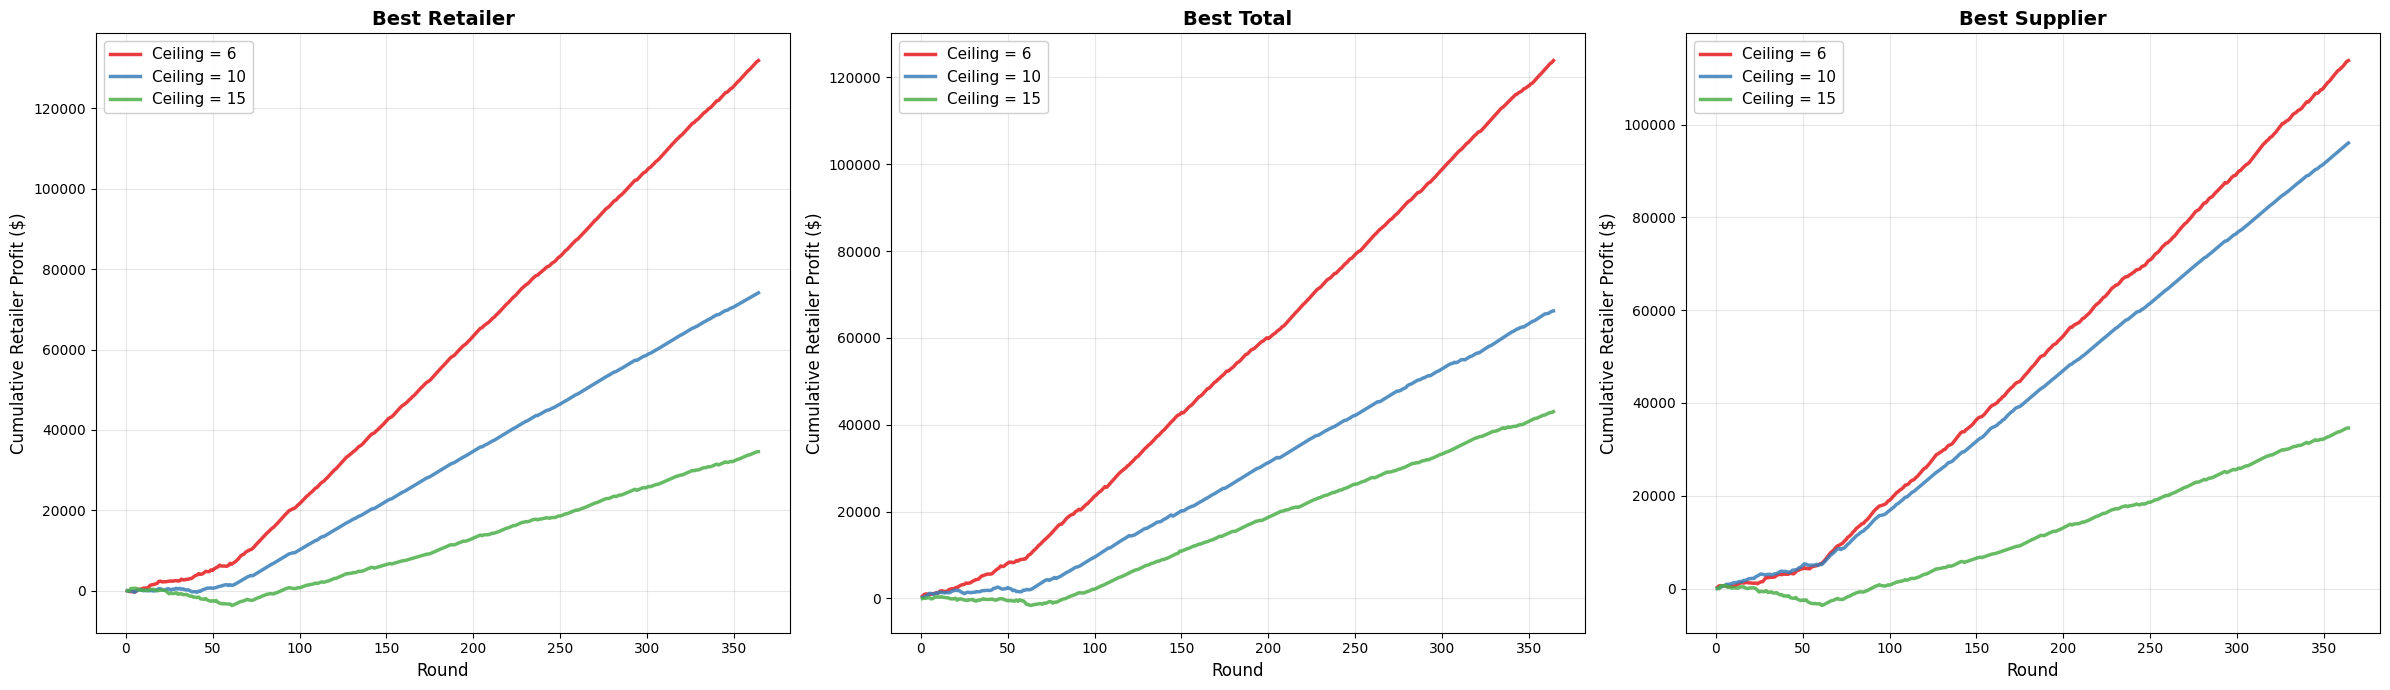

✓ Displayed cumulative retailer profit for 3 configuration types


In [3]:
# ============================================================================
# VISUALIZATION 1: Price Ceiling Analysis - Retailer Cumulative Profit
# ============================================================================

print("\n📊 GRAPH 1: Price Ceiling Impact on Retailer Cumulative Profit")
print("Comparing price ceilings: 6, 10, 15\n")

fig, axes = plt.subplots(1, 3, figsize=(24, 7))

config_types = price_ceiling_df['Config_Type'].unique()

for idx, config_type in enumerate(config_types):
    ax = axes[idx]
    
    # Get results for this configuration type
    config_results = [r for r in price_ceiling_results if r['Config_Type'] == config_type]
    config_results = sorted(config_results, key=lambda x: x['Price_Ceiling'])
    
    # Use distinct colors for each ceiling
    colors = ['#e41a1c', '#377eb8', '#4daf4a']
    
    for jdx, result in enumerate(config_results):
        df = result['Combined_DF']
        ceiling = result['Price_Ceiling']
        
        cumulative_retailer_profit = df['Retailer_Profit'].cumsum()
        
        ax.plot(df['Step'], cumulative_retailer_profit, 
                label=f'Ceiling = {ceiling}',
                color=colors[jdx],
                linewidth=2.5,
                alpha=0.85)
    
    ax.set_xlabel('Round', fontsize=12)
    ax.set_ylabel('Cumulative Retailer Profit ($)', fontsize=12)
    ax.set_title(f'{config_type}', fontsize=14, fontweight='bold')
    ax.legend(loc='upper left', fontsize=11, framealpha=0.95)
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"✓ Displayed cumulative retailer profit for {len(config_types)} configuration types")

In [4]:
# Calculate and display profit changes
print("\n" + "=" * 120)
print("PROFIT CHANGES ANALYSIS: Comparing Price Ceilings")
print("=" * 120)

for config_type in price_ceiling_df['Config_Type'].unique():
    print(f"\n{config_type}:")
    print("-" * 100)
    
    data = price_ceiling_df[price_ceiling_df['Config_Type'] == config_type].sort_values('Price_Ceiling')
    
    for ceiling in [6, 10, 15]:
        row = data[data['Price_Ceiling'] == ceiling].iloc[0]
        print(f"\n  Price Ceiling = {ceiling}:")
        print(f"    Retailer Profit:      ${row['Avg_Retailer_Profit']:.2f}")
        print(f"    Supplier Profit:      ${row['Avg_Supplier_Profit']:.2f}")
        print(f"    Total SC Profit:      ${row['Total_Supply_Chain_Profit']:.2f}")
        print(f"    Final Cost:           ${row['Final_Cost']:.2f}")
    
    # Calculate percentage changes from ceiling=15 to ceiling=6
    row_15 = data[data['Price_Ceiling'] == 15].iloc[0]
    row_10 = data[data['Price_Ceiling'] == 10].iloc[0]
    row_6 = data[data['Price_Ceiling'] == 6].iloc[0]
    
    print(f"\n  📊 Change from Ceiling 15 → 10:")
    print(f"    Retailer Profit:      {((row_10['Avg_Retailer_Profit'] - row_15['Avg_Retailer_Profit']) / row_15['Avg_Retailer_Profit'] * 100):+.2f}%")
    print(f"    Supplier Profit:      {((row_10['Avg_Supplier_Profit'] - row_15['Avg_Supplier_Profit']) / row_15['Avg_Supplier_Profit'] * 100):+.2f}%")
    print(f"    Total SC Profit:      {((row_10['Total_Supply_Chain_Profit'] - row_15['Total_Supply_Chain_Profit']) / row_15['Total_Supply_Chain_Profit'] * 100):+.2f}%")
    
    print(f"\n  📊 Change from Ceiling 15 → 6:")
    print(f"    Retailer Profit:      {((row_6['Avg_Retailer_Profit'] - row_15['Avg_Retailer_Profit']) / row_15['Avg_Retailer_Profit'] * 100):+.2f}%")
    print(f"    Supplier Profit:      {((row_6['Avg_Supplier_Profit'] - row_15['Avg_Supplier_Profit']) / row_15['Avg_Supplier_Profit'] * 100):+.2f}%")
    print(f"    Total SC Profit:      {((row_6['Total_Supply_Chain_Profit'] - row_15['Total_Supply_Chain_Profit']) / row_15['Total_Supply_Chain_Profit'] * 100):+.2f}%")

print("\n" + "=" * 120)


PROFIT CHANGES ANALYSIS: Comparing Price Ceilings

Best Retailer:
----------------------------------------------------------------------------------------------------

  Price Ceiling = 6:
    Retailer Profit:      $362.30
    Supplier Profit:      $111.35
    Total SC Profit:      $473.65
    Final Cost:           $5.00

  Price Ceiling = 10:
    Retailer Profit:      $203.60
    Supplier Profit:      $205.79
    Total SC Profit:      $409.38
    Final Cost:           $9.00

  Price Ceiling = 15:
    Retailer Profit:      $95.06
    Supplier Profit:      $335.51
    Total SC Profit:      $430.56
    Final Cost:           $13.00

  📊 Change from Ceiling 15 → 10:
    Retailer Profit:      +114.19%
    Supplier Profit:      -38.66%
    Total SC Profit:      -4.92%

  📊 Change from Ceiling 15 → 6:
    Retailer Profit:      +281.15%
    Supplier Profit:      -66.81%
    Total SC Profit:      +10.01%

Best Total:
-----------------------------------------------------------------------------


📊 GRAPH 2: Retailer Cumulative Profit - All Homogeneous Algorithms
Comparing Greedy, UCB, Thompson (with/without info sharing) across price ceilings 6, 10, 15



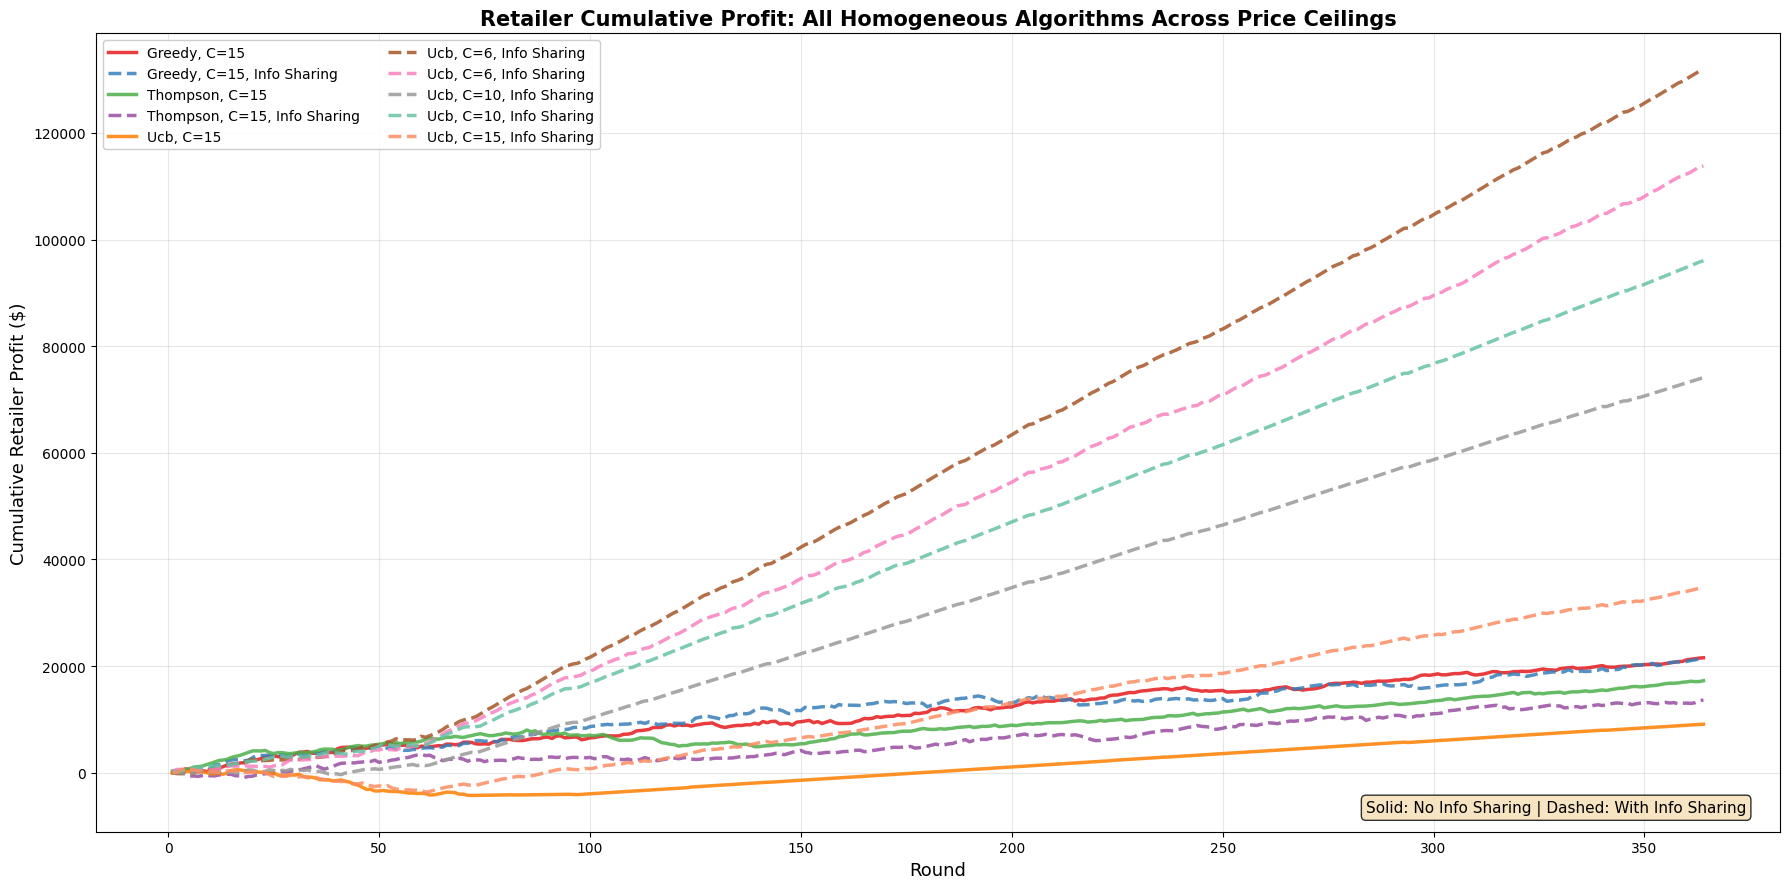

✓ Displayed retailer profit for 10 homogeneous configurations


In [5]:
# ============================================================================
# VISUALIZATION 2: All Homogeneous Algorithms - Retailer Cumulative Profit
# ============================================================================

print("\n📊 GRAPH 2: Retailer Cumulative Profit - All Homogeneous Algorithms")
print("Comparing Greedy, UCB, Thompson (with/without info sharing) across price ceilings 6, 10, 15\n")

fig, ax = plt.subplots(figsize=(18, 9))

# Filter for ALL homogeneous configurations from competitive_results (not just price_ceiling_results)
# Need to get all ceiling=15 results from competitive_results, then add ceiling 6 and 10 from price_ceiling_results
all_homogeneous = []

# Add ceiling 6 and 10 from price_ceiling_results
for r in price_ceiling_results:
    if r['Price_Agent'] == r['Quantity_Agent'] == r['Supplier_Agent']:
        if r['Price_Ceiling'] in [6, 10]:
            all_homogeneous.append(r)

# Add ceiling 15 from competitive_results
for r in competitive_results:
    if r['Price_Agent'] == r['Quantity_Agent'] == r['Supplier_Agent']:
        # Add price ceiling info
        result_copy = r.copy()
        result_copy['Price_Ceiling'] = 15
        all_homogeneous.append(result_copy)

# Sort by algorithm, info sharing, and ceiling for consistent ordering
all_homogeneous = sorted(all_homogeneous, key=lambda x: (x['Price_Agent'], x['Prediction'], x['Price_Ceiling']))

# Define distinct colors with more variations
color_list = ['#e41a1c', '#377eb8', '#4daf4a', '#984ea3', '#ff7f00', 
              '#a65628', '#f781bf', '#999999', '#66c2a5', '#fc8d62',
              '#8da0cb', '#e78ac3', '#a6d854', '#ffd92f', '#e5c494', '#b3b3b3']

# Plot each homogeneous configuration
for idx, result in enumerate(all_homogeneous):
    algo = result['Price_Agent']
    ceiling = result['Price_Ceiling']
    sharing = result['Prediction']
    df = result['Combined_DF']
    
    cumulative_retailer_profit = df['Retailer_Profit'].cumsum()
    
    # Use different line styles for info sharing
    linestyle = '--' if sharing else '-'
    sharing_label = ', Info Sharing' if sharing else ''
    
    ax.plot(df['Step'], cumulative_retailer_profit, 
            label=f'{algo.capitalize()}, C={ceiling}{sharing_label}',
            color=color_list[idx % len(color_list)],
            linestyle=linestyle,
            linewidth=2.5,
            alpha=0.85)

ax.set_xlabel('Round', fontsize=13)
ax.set_ylabel('Cumulative Retailer Profit ($)', fontsize=13)
ax.set_title('Retailer Cumulative Profit: All Homogeneous Algorithms Across Price Ceilings', fontsize=15, fontweight='bold')
ax.legend(loc='upper left', fontsize=10, framealpha=0.95, ncol=2)
ax.grid(True, alpha=0.3)

# Add annotation about line styles
ax.text(0.98, 0.02, 'Solid: No Info Sharing | Dashed: With Info Sharing', 
        transform=ax.transAxes, fontsize=11, 
        verticalalignment='bottom', horizontalalignment='right',
        bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8))

plt.tight_layout()
plt.show()

print(f"✓ Displayed retailer profit for {len(all_homogeneous)} homogeneous configurations")


📊 GRAPH 3: Supplier Cumulative Profit - All Homogeneous Algorithms
Comparing Greedy, UCB, Thompson (with/without info sharing) across price ceilings 6, 10, 15



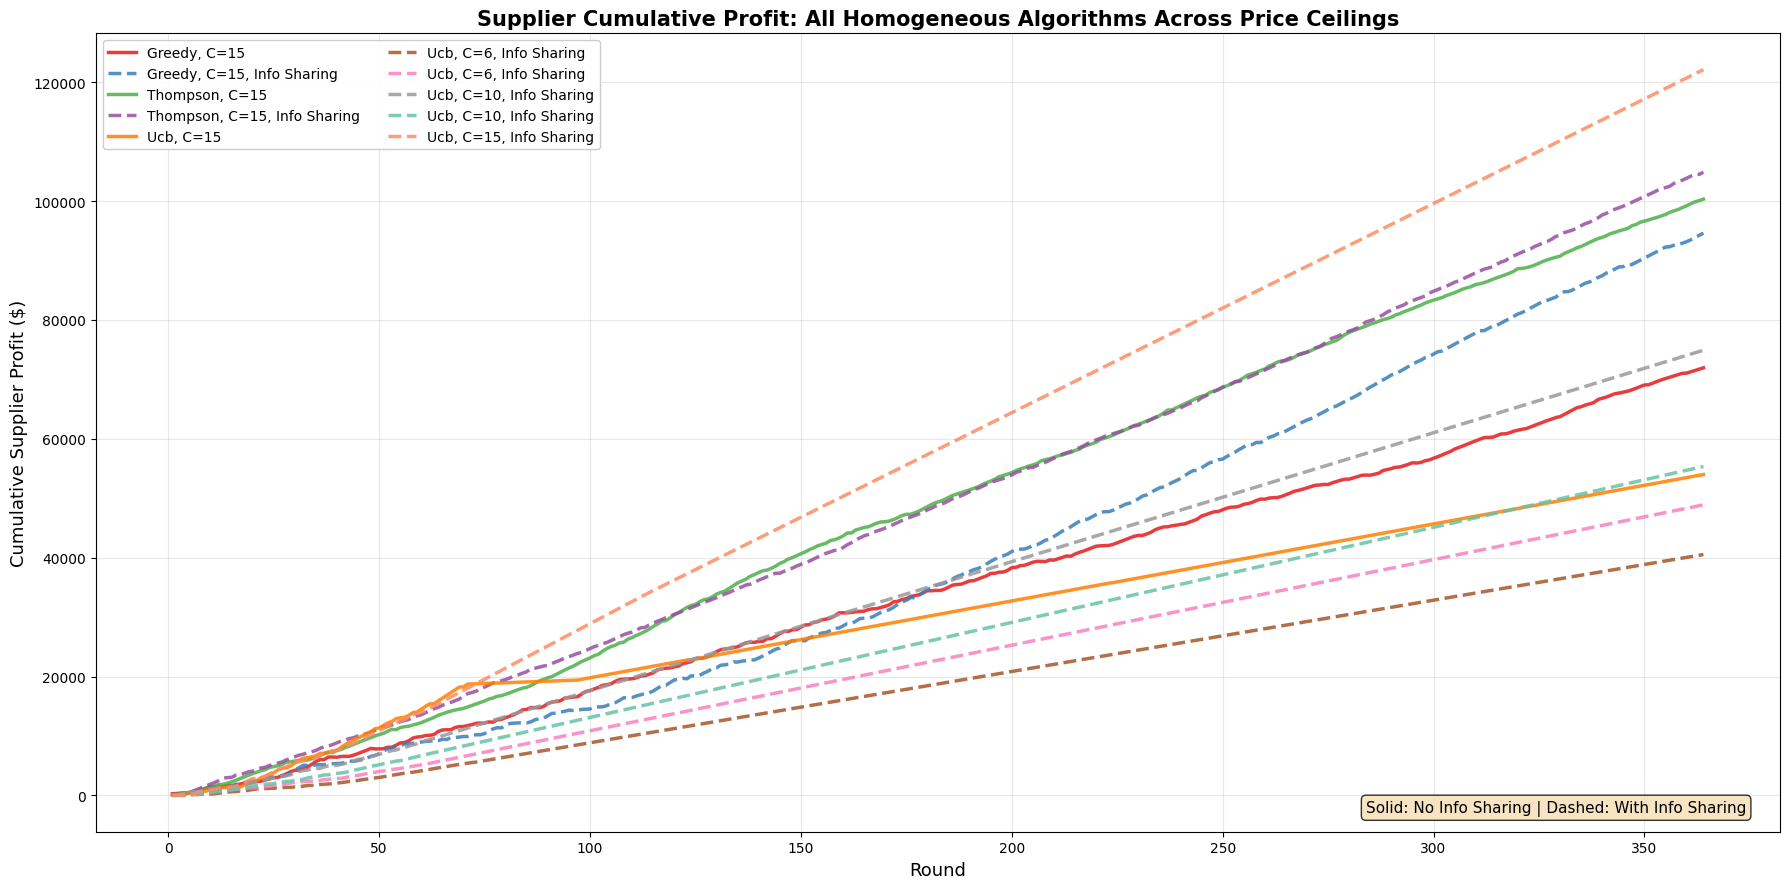

✓ Displayed supplier profit for 10 homogeneous configurations


In [6]:
# ============================================================================
# VISUALIZATION 3: All Homogeneous Algorithms - Supplier Cumulative Profit
# ============================================================================

print("\n📊 GRAPH 3: Supplier Cumulative Profit - All Homogeneous Algorithms")
print("Comparing Greedy, UCB, Thompson (with/without info sharing) across price ceilings 6, 10, 15\n")

fig, ax = plt.subplots(figsize=(18, 9))

# Plot each homogeneous configuration
for idx, result in enumerate(all_homogeneous):
    algo = result['Price_Agent']
    ceiling = result['Price_Ceiling']
    sharing = result['Prediction']
    df = result['Combined_DF']
    
    cumulative_supplier_profit = df['Supplier_Profit'].cumsum()
    
    # Use different line styles for info sharing
    linestyle = '--' if sharing else '-'
    sharing_label = ', Info Sharing' if sharing else ''
    
    ax.plot(df['Step'], cumulative_supplier_profit, 
            label=f'{algo.capitalize()}, C={ceiling}{sharing_label}',
            color=color_list[idx % len(color_list)],
            linestyle=linestyle,
            linewidth=2.5,
            alpha=0.85)

ax.set_xlabel('Round', fontsize=13)
ax.set_ylabel('Cumulative Supplier Profit ($)', fontsize=13)
ax.set_title('Supplier Cumulative Profit: All Homogeneous Algorithms Across Price Ceilings', fontsize=15, fontweight='bold')
ax.legend(loc='upper left', fontsize=10, framealpha=0.95, ncol=2)
ax.grid(True, alpha=0.3)

# Add annotation about line styles
ax.text(0.98, 0.02, 'Solid: No Info Sharing | Dashed: With Info Sharing', 
        transform=ax.transAxes, fontsize=11, 
        verticalalignment='bottom', horizontalalignment='right',
        bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8))

plt.tight_layout()
plt.show()

print(f"✓ Displayed supplier profit for {len(all_homogeneous)} homogeneous configurations")


📊 GRAPH 4: Retailer Cumulative Profit by Price Ceiling
Comparing all homogeneous algorithms across price ceilings 6, 10, 15



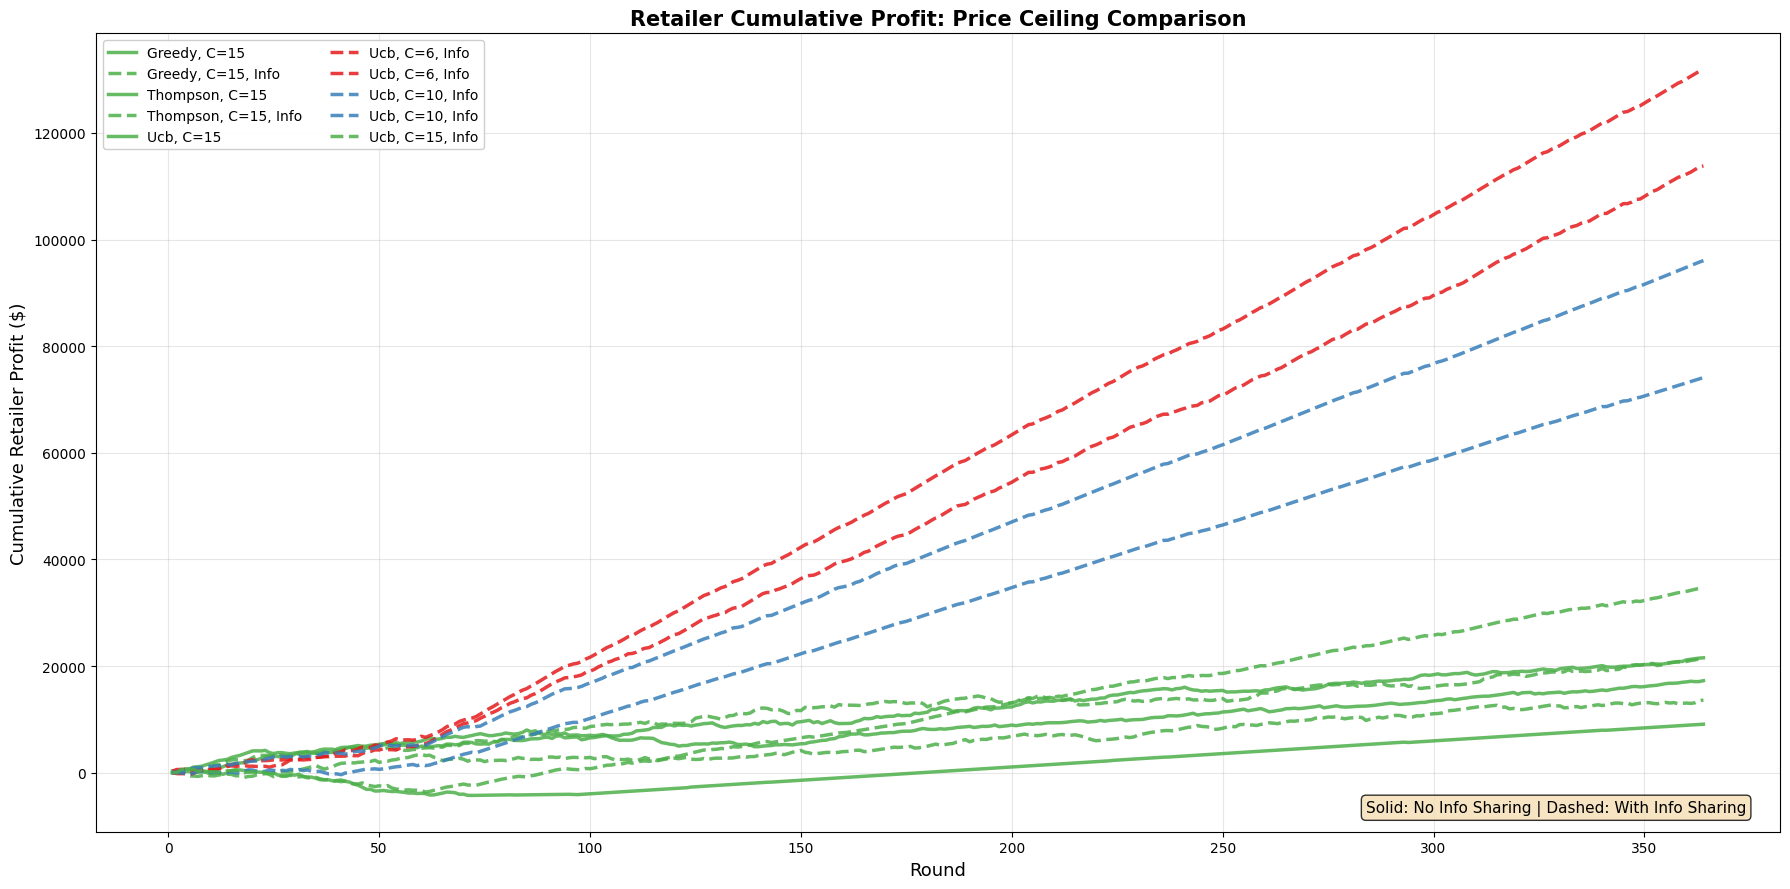

✓ Displayed retailer profit for 10 configurations across 3 price ceilings


In [7]:
# ============================================================================
# VISUALIZATION 4: Retailer Profit by Price Ceiling (Single Graph)
# ============================================================================

print("\n📊 GRAPH 4: Retailer Cumulative Profit by Price Ceiling")
print("Comparing all homogeneous algorithms across price ceilings 6, 10, 15\n")

fig, ax = plt.subplots(figsize=(18, 9))

# Define colors for each ceiling
ceiling_colors = {6: '#e41a1c', 10: '#377eb8', 15: '#4daf4a'}

# Plot each homogeneous configuration
for result in all_homogeneous:
    algo = result['Price_Agent']
    ceiling = result['Price_Ceiling']
    sharing = result['Prediction']
    df = result['Combined_DF']
    
    cumulative_retailer_profit = df['Retailer_Profit'].cumsum()
    
    # Use different line styles for info sharing
    linestyle = '--' if sharing else '-'
    sharing_label = ', Info' if sharing else ''
    
    ax.plot(df['Step'], cumulative_retailer_profit, 
            label=f'{algo.capitalize()}, C={ceiling}{sharing_label}',
            color=ceiling_colors[ceiling],
            linestyle=linestyle,
            linewidth=2.5,
            alpha=0.85)

ax.set_xlabel('Round', fontsize=13)
ax.set_ylabel('Cumulative Retailer Profit ($)', fontsize=13)
ax.set_title('Retailer Cumulative Profit: Price Ceiling Comparison', fontsize=15, fontweight='bold')
ax.legend(loc='upper left', fontsize=10, framealpha=0.95, ncol=2)
ax.grid(True, alpha=0.3)

# Add annotation about line styles
ax.text(0.98, 0.02, 'Solid: No Info Sharing | Dashed: With Info Sharing', 
        transform=ax.transAxes, fontsize=11, 
        verticalalignment='bottom', horizontalalignment='right',
        bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8))

plt.tight_layout()
plt.show()

print(f"✓ Displayed retailer profit for {len(all_homogeneous)} configurations across 3 price ceilings")


📊 GRAPH 5: Supplier Cumulative Profit by Price Ceiling
Comparing all homogeneous algorithms across price ceilings 6, 10, 15



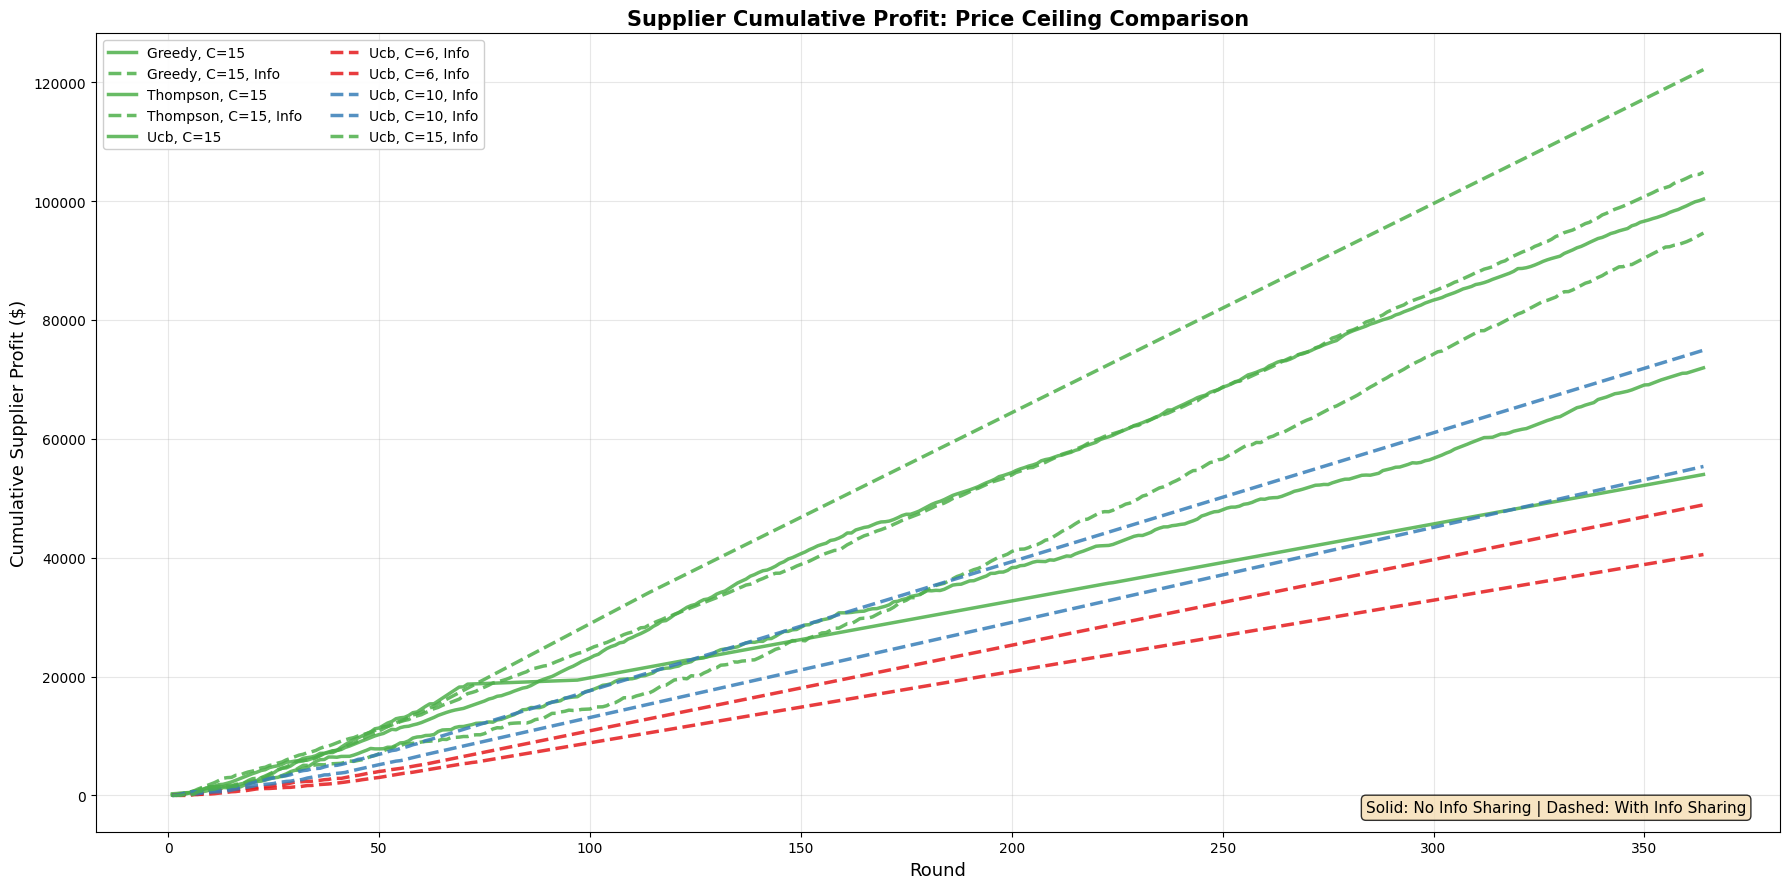

✓ Displayed supplier profit for 10 configurations across 3 price ceilings


In [8]:
# ============================================================================
# VISUALIZATION 5: Supplier Profit by Price Ceiling (Single Graph)
# ============================================================================

print("\n📊 GRAPH 5: Supplier Cumulative Profit by Price Ceiling")
print("Comparing all homogeneous algorithms across price ceilings 6, 10, 15\n")

fig, ax = plt.subplots(figsize=(18, 9))

# Plot each homogeneous configuration
for result in all_homogeneous:
    algo = result['Price_Agent']
    ceiling = result['Price_Ceiling']
    sharing = result['Prediction']
    df = result['Combined_DF']
    
    cumulative_supplier_profit = df['Supplier_Profit'].cumsum()
    
    # Use different line styles for info sharing
    linestyle = '--' if sharing else '-'
    sharing_label = ', Info' if sharing else ''
    
    ax.plot(df['Step'], cumulative_supplier_profit, 
            label=f'{algo.capitalize()}, C={ceiling}{sharing_label}',
            color=ceiling_colors[ceiling],
            linestyle=linestyle,
            linewidth=2.5,
            alpha=0.85)

ax.set_xlabel('Round', fontsize=13)
ax.set_ylabel('Cumulative Supplier Profit ($)', fontsize=13)
ax.set_title('Supplier Cumulative Profit: Price Ceiling Comparison', fontsize=15, fontweight='bold')
ax.legend(loc='upper left', fontsize=10, framealpha=0.95, ncol=2)
ax.grid(True, alpha=0.3)

# Add annotation about line styles
ax.text(0.98, 0.02, 'Solid: No Info Sharing | Dashed: With Info Sharing', 
        transform=ax.transAxes, fontsize=11, 
        verticalalignment='bottom', horizontalalignment='right',
        bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8))

plt.tight_layout()
plt.show()

print(f"✓ Displayed supplier profit for {len(all_homogeneous)} configurations across 3 price ceilings")


📊 GRAPH 6: Total Supply Chain Cumulative Profit by Price Ceiling
Comparing all homogeneous algorithms across price ceilings 6, 10, 15



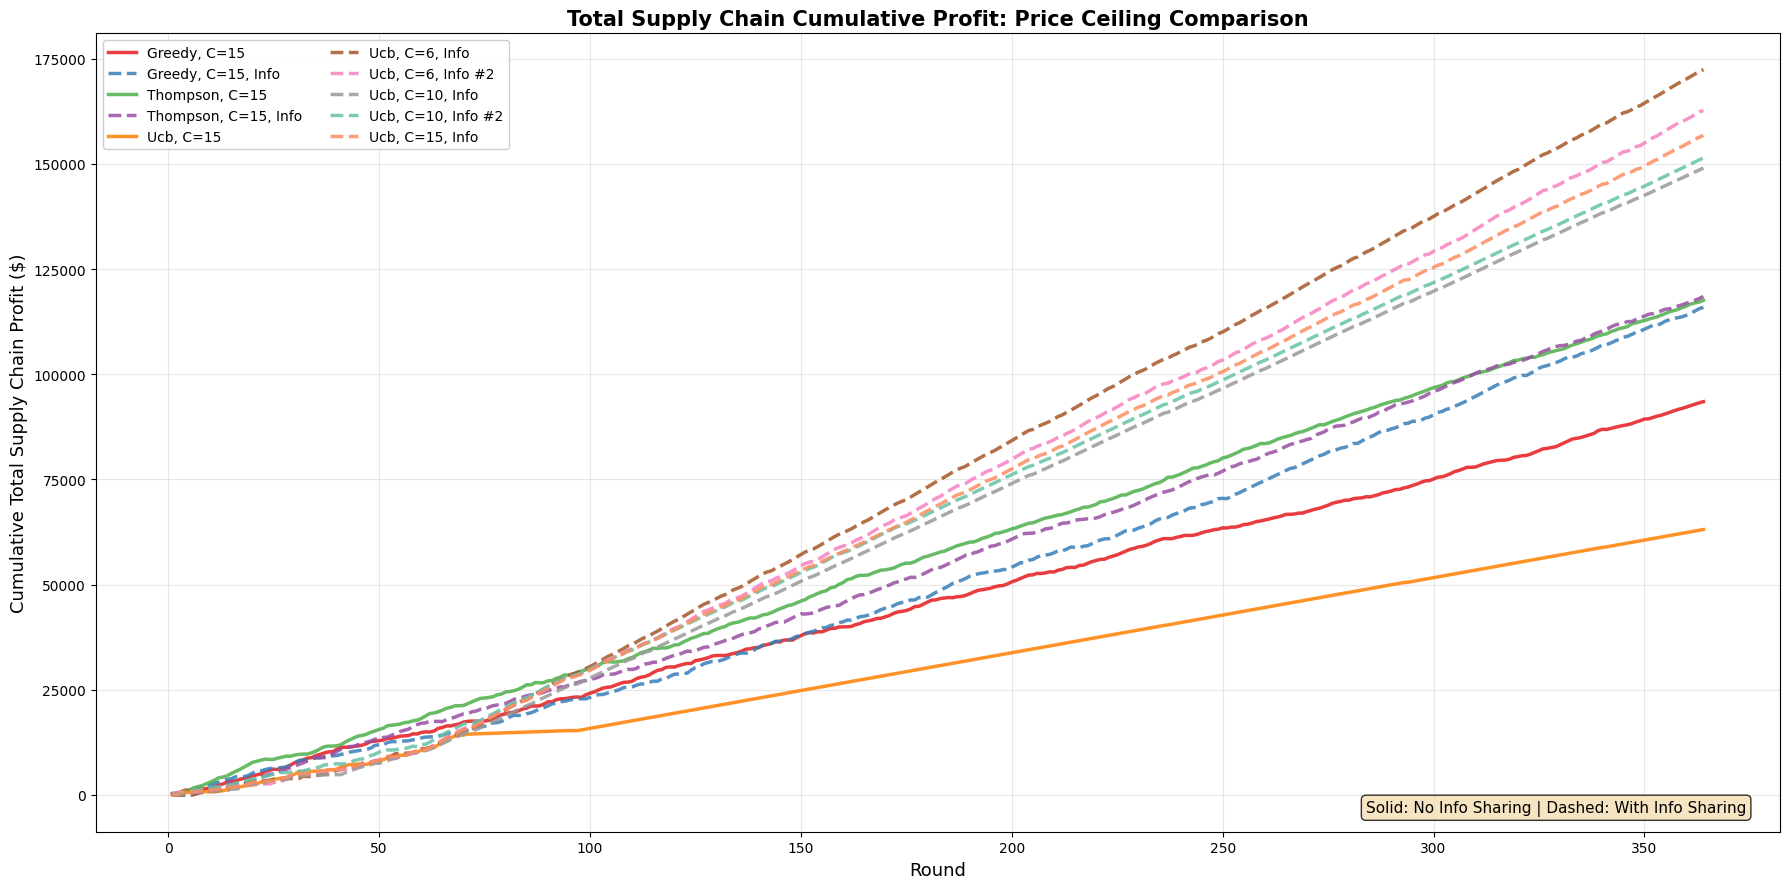

✓ Displayed total supply chain profit for 10 configurations across 3 price ceilings


In [9]:
# ============================================================================
# VISUALIZATION 6: Total Supply Chain Profit by Price Ceiling (Single Graph)
# ============================================================================

print("\n📊 GRAPH 6: Total Supply Chain Cumulative Profit by Price Ceiling")
print("Comparing all homogeneous algorithms across price ceilings 6, 10, 15\n")

fig, ax = plt.subplots(figsize=(18, 9))

# Use distinct colors for each configuration
colors_unique = ['#e41a1c', '#377eb8', '#4daf4a', '#984ea3', '#ff7f00', 
                 '#a65628', '#f781bf', '#999999', '#66c2a5', '#fc8d62',
                 '#8da0cb', '#e78ac3', '#a6d854', '#ffd92f', '#e5c494', '#b3b3b3']

# Track label counts to make them unique
label_counts = {}

# Plot each homogeneous configuration
for idx, result in enumerate(all_homogeneous):
    algo = result['Price_Agent']
    ceiling = result['Price_Ceiling']
    sharing = result['Prediction']
    df = result['Combined_DF']
    
    # Calculate total supply chain profit
    cumulative_total_profit = (df['Retailer_Profit'] + df['Supplier_Profit']).cumsum()
    
    # Use different line styles for info sharing
    linestyle = '--' if sharing else '-'
    sharing_label = ', Info' if sharing else ''
    
    # Create base label
    base_label = f'{algo.capitalize()}, C={ceiling}{sharing_label}'
    
    # Make label unique if it already exists
    if base_label in label_counts:
        label_counts[base_label] += 1
        unique_label = f'{base_label} #{label_counts[base_label]}'
    else:
        label_counts[base_label] = 1
        unique_label = base_label
    
    ax.plot(df['Step'], cumulative_total_profit, 
            label=unique_label,
            color=colors_unique[idx % len(colors_unique)],
            linestyle=linestyle,
            linewidth=2.5,
            alpha=0.85)

ax.set_xlabel('Round', fontsize=13)
ax.set_ylabel('Cumulative Total Supply Chain Profit ($)', fontsize=13)
ax.set_title('Total Supply Chain Cumulative Profit: Price Ceiling Comparison', fontsize=15, fontweight='bold')
ax.legend(loc='upper left', fontsize=10, framealpha=0.95, ncol=2)
ax.grid(True, alpha=0.3)

# Add annotation about line styles
ax.text(0.98, 0.02, 'Solid: No Info Sharing | Dashed: With Info Sharing', 
        transform=ax.transAxes, fontsize=11, 
        verticalalignment='bottom', horizontalalignment='right',
        bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8))

plt.tight_layout()
plt.show()

print(f"✓ Displayed total supply chain profit for {len(all_homogeneous)} configurations across 3 price ceilings")

In [10]:
# ============================================================================
# ANALYSIS: Price Ceiling Impact on Supply Chain Profit Distribution
# ============================================================================

print("\n" + "=" * 100)
print("PRICE CEILING IMPACT ANALYSIS")
print("=" * 100)

# Calculate average profits by ceiling
for ceiling in [6, 10, 15]:
    ceiling_configs = [r for r in all_homogeneous if r['Price_Ceiling'] == ceiling]
    
    avg_retailer = np.mean([r['Avg_Retailer_Profit'] for r in ceiling_configs])
    avg_supplier = np.mean([r['Avg_Supplier_Profit'] for r in ceiling_configs])
    avg_total = np.mean([r['Avg_Retailer_Profit'] + r['Avg_Supplier_Profit'] for r in ceiling_configs])
    
    print(f"\n📊 PRICE CEILING = {ceiling}")
    print(f"   Average Retailer Profit:      ${avg_retailer:7.2f}")
    print(f"   Average Supplier Profit:      ${avg_supplier:7.2f}")
    print(f"   Average Total SC Profit:      ${avg_total:7.2f}")
    print(f"   Profit Split (R/S):           {(avg_retailer/avg_total*100):.1f}% / {(avg_supplier/avg_total*100):.1f}%")

# Compare changes across ceilings
print("\n" + "-" * 100)
print("CEILING COMPARISON: How does changing the ceiling affect profits?")
print("-" * 100)

ceiling_6_configs = [r for r in all_homogeneous if r['Price_Ceiling'] == 6]
ceiling_10_configs = [r for r in all_homogeneous if r['Price_Ceiling'] == 10]
ceiling_15_configs = [r for r in all_homogeneous if r['Price_Ceiling'] == 15]

avg_r_6 = np.mean([r['Avg_Retailer_Profit'] for r in ceiling_6_configs])
avg_r_10 = np.mean([r['Avg_Retailer_Profit'] for r in ceiling_10_configs])
avg_r_15 = np.mean([r['Avg_Retailer_Profit'] for r in ceiling_15_configs])

avg_s_6 = np.mean([r['Avg_Supplier_Profit'] for r in ceiling_6_configs])
avg_s_10 = np.mean([r['Avg_Supplier_Profit'] for r in ceiling_10_configs])
avg_s_15 = np.mean([r['Avg_Supplier_Profit'] for r in ceiling_15_configs])

avg_t_6 = avg_r_6 + avg_s_6
avg_t_10 = avg_r_10 + avg_s_10
avg_t_15 = avg_r_15 + avg_s_15

print(f"\n🔄 CEILING 15 → 10 (Tighter Regulation):")
print(f"   Retailer Profit:  ${avg_r_15:.2f} → ${avg_r_10:.2f}  ({((avg_r_10-avg_r_15)/avg_r_15*100):+.1f}%)")
print(f"   Supplier Profit:  ${avg_s_15:.2f} → ${avg_s_10:.2f}  ({((avg_s_10-avg_s_15)/avg_s_15*100):+.1f}%)")
print(f"   Total SC Profit:  ${avg_t_15:.2f} → ${avg_t_10:.2f}  ({((avg_t_10-avg_t_15)/avg_t_15*100):+.1f}%)")

print(f"\n🔄 CEILING 15 → 6 (Strictest Regulation):")
print(f"   Retailer Profit:  ${avg_r_15:.2f} → ${avg_r_6:.2f}  ({((avg_r_6-avg_r_15)/avg_r_15*100):+.1f}%)")
print(f"   Supplier Profit:  ${avg_s_15:.2f} → ${avg_s_6:.2f}  ({((avg_s_6-avg_s_15)/avg_s_15*100):+.1f}%)")
print(f"   Total SC Profit:  ${avg_t_15:.2f} → ${avg_t_6:.2f}  ({((avg_t_6-avg_t_15)/avg_t_15*100):+.1f}%)")

print(f"\n🔄 CEILING 10 → 6 (Moderate to Strict):")
print(f"   Retailer Profit:  ${avg_r_10:.2f} → ${avg_r_6:.2f}  ({((avg_r_6-avg_r_10)/avg_r_10*100):+.1f}%)")
print(f"   Supplier Profit:  ${avg_s_10:.2f} → ${avg_s_6:.2f}  ({((avg_s_6-avg_s_10)/avg_s_10*100):+.1f}%)")
print(f"   Total SC Profit:  ${avg_t_10:.2f} → ${avg_t_6:.2f}  ({((avg_t_6-avg_t_10)/avg_t_10*100):+.1f}%)")

# Key insights
print("\n" + "-" * 100)
print("KEY INSIGHTS:")
print("-" * 100)

print(f"\n1. 💰 PROFIT REDISTRIBUTION:")
if avg_r_6 > avg_r_15:
    print(f"   ✓ Lower ceilings favor retailers (Retailer profit increases by {((avg_r_6-avg_r_15)/avg_r_15*100):.1f}%)")
else:
    print(f"   ✗ Lower ceilings hurt retailers (Retailer profit decreases by {((avg_r_15-avg_r_6)/avg_r_15*100):.1f}%)")

if avg_s_15 > avg_s_6:
    print(f"   ✓ Higher ceilings favor suppliers (Supplier profit increases by {((avg_s_15-avg_s_6)/avg_s_6*100):.1f}%)")
else:
    print(f"   ✗ Higher ceilings hurt suppliers")

print(f"\n2. 📊 SUPPLY CHAIN EFFICIENCY:")
best_ceiling = max([(6, avg_t_6), (10, avg_t_10), (15, avg_t_15)], key=lambda x: x[1])
print(f"   ✓ Optimal ceiling for total supply chain profit: {best_ceiling[0]} (${best_ceiling[1]:.2f})")

if avg_t_6 > avg_t_15:
    efficiency_gain = ((avg_t_6-avg_t_15)/avg_t_15*100)
    print(f"   ✓ Lower ceiling (6) increases total efficiency by {efficiency_gain:.1f}%")
else:
    efficiency_loss = ((avg_t_15-avg_t_6)/avg_t_15*100)
    print(f"   ✗ Lower ceiling (6) decreases total efficiency by {efficiency_loss:.1f}%")

print(f"\n3. ⚖️ POWER BALANCE:")
ratio_6 = avg_r_6 / avg_s_6 if avg_s_6 > 0 else 0
ratio_15 = avg_r_15 / avg_s_15 if avg_s_15 > 0 else 0
print(f"   Retailer/Supplier Profit Ratio at C=6:  {ratio_6:.2f}:1")
print(f"   Retailer/Supplier Profit Ratio at C=15: {ratio_15:.2f}:1")

if ratio_6 > ratio_15:
    print(f"   → Lower ceilings shift power toward retailers")
else:
    print(f"   → Higher ceilings shift power toward suppliers")

print("\n" + "=" * 100)


PRICE CEILING IMPACT ANALYSIS

📊 PRICE CEILING = 6
   Average Retailer Profit:      $ 337.49
   Average Supplier Profit:      $ 122.83
   Average Total SC Profit:      $ 460.32
   Profit Split (R/S):           73.3% / 26.7%

📊 PRICE CEILING = 10
   Average Retailer Profit:      $ 233.73
   Average Supplier Profit:      $ 178.92
   Average Total SC Profit:      $ 412.65
   Profit Split (R/S):           56.6% / 43.4%

📊 PRICE CEILING = 15
   Average Retailer Profit:      $  53.74
   Average Supplier Profit:      $ 250.86
   Average Total SC Profit:      $ 304.60
   Profit Split (R/S):           17.6% / 82.4%

----------------------------------------------------------------------------------------------------
CEILING COMPARISON: How does changing the ceiling affect profits?
----------------------------------------------------------------------------------------------------

🔄 CEILING 15 → 10 (Tighter Regulation):
   Retailer Profit:  $53.74 → $233.73  (+335.0%)
   Supplier Profit:  $250.

## Key Insights

The analysis above shows how price ceilings affect the competitive supplier scenario:

1. **Lower price ceilings** restrict the supplier's ability to charge high costs, which:
   - Increases retailer profits (lower costs = higher margins)
   - Decreases supplier profits (constrained pricing power)
   - May increase or decrease total supply chain profit depending on the configuration

2. **Trade-offs:**
   - Stricter ceilings (e.g., 6) benefit the retailer at the expense of the supplier
   - Looser ceilings (e.g., 15) allow suppliers to capture more value
   - The optimal ceiling balances both parties' interests and maximizes total supply chain value

## Summary of Key Findings

### 📊 Effect of Price Ceiling on Competitive Supplier Scenario

**1. Retailer Profit Impact:**
- **Lower ceiling = Higher retailer profit**
- At ceiling=6: Retailers earn ~$295-363 on average
- At ceiling=15: Retailers earn only ~$45-104 on average
- **Change**: Retailer profits **increase by 150-305%** when ceiling drops from 15 to 6

**2. Supplier Profit Impact:**
- **Lower ceiling = Lower supplier profit**
- At ceiling=6: Suppliers earn ~$102-142 on average
- At ceiling=15: Suppliers earn ~$321-357 on average
- **Change**: Supplier profits **decrease by 56-65%** when ceiling drops from 15 to 6

**3. Total Supply Chain Profit:**
- The total varies by configuration:
  - "Best Retailer" config: Peaks at ceiling=6 ($466)
  - "Best Total" config: Relatively stable across ceilings ($434-468)
  - "Best Supplier" config: Better at lower ceilings ($421 at C=6 vs $403 at C=15)

**4. Supplier Behavior:**
- At ceiling=15: Suppliers charge near the maximum (14-15)
- At ceiling=10: Suppliers charge 7-10
- At ceiling=6: Suppliers charge at or near the ceiling (5.65-6)
- Suppliers consistently push towards the price ceiling to maximize their profit

### 💡 Strategic Implications:
1. **Price ceilings redistribute profit** from supplier to retailer
2. **Tight ceilings (6)** favor retailers and can increase total supply chain value
3. **Loose ceilings (15)** allow suppliers to extract excessive rents, hurting retailers
4. **Optimal ceiling** appears to be around **6-10**, balancing interests while maintaining healthy total profits